# Peak Finding
This notebook generates some mangled peak-like spectra. The goal is to test whether the peaks can be resolved properly and robustly. Secondly, we want to test that convolutional peakfinding works accurately

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lightlab.util.measprocessing as mp
import lightlab.util.data as dUtil

In [2]:
# Make a simple spectrum with peaks
def lorentzian(x, a, c, g):
    return a / (1 + ((x - c) / g*2) ** 2)

tNM = np.linspace(1500, 1600, 1000)
def noise():
    noiz = np.clip(np.random.randn(len(tNM)) * 1e-3, 1e-6, None)
    return dUtil.Spectrum(tNM, noiz, inDbm=False).lin()

def makeTest(lams):
    pk = [(lams[0], .9, 2)]
    pk = pk + [(lams[0] + 2, .85, 1), (lams[0] + 3, .85, .5)]
    if len(lams) > 1:
        pk = pk + [(lams[1], .1e-1, 1)]
    tLIN = np.zeros(tNM.shape)

    for p in pk:
        tLIN = tLIN + lorentzian(tNM, p[1], p[0], p[2])
    sig = dUtil.Spectrum(tNM, tLIN, inDbm=False)
    sig += noise()
    return sig.db()

lams = [1530, 1555]
s = makeTest(lams)
npk = len(lams)

## Using measured function methods
The measured function is ``s``

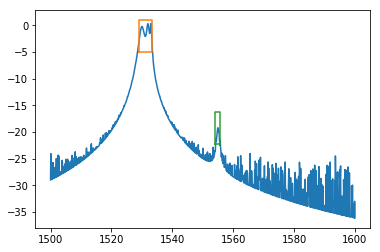

In [3]:
resonanceFeatures = s.findResonanceFeatures(expectedCnt=2, isPeak=True)
s.simplePlot()
[r.simplePlot() for r in resonanceFeatures] # ResonanceFeatures have their own plotting method

assert abs(resonanceFeatures[0].lam - lams[0]) < 2
assert abs(resonanceFeatures[1].lam - lams[1]) < 2

## Using Spectrum Measurement Assistant
This is better when you are taking many spectra of something that doesn't change very much

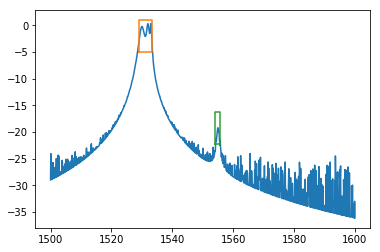

In [4]:
# Setup measurement assistant
spcAss = mp.SpectrumMeasurementAssistant(nChan=npk, arePeaks=True)
spcAss.fgResPlot(s)

# res = spcAss.resonances(s)
# print('Found lambdas =', [r.lam for r in res])
# print('Error =', [res[i].lam - lams[i] for i in range(len(res))])
# offsets = np.array([res[i].lam - lams[i] for i in range(len(res))])

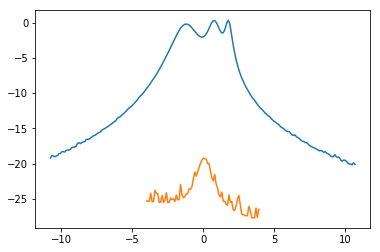

In [5]:
# take filter shapes and store in assistant
filtShapes = np.empty(npk, dtype=object)
for i, r in enumerate(spcAss.resonances(s)):
    relWindow = 5 * r.fwhm * np.array([-1,1])/2 # pick out 5 FWHMs
    proximitySpect = s.shift(-r.lam).crop(relWindow) # crop out the peak
    filtShapes[i] = proximitySpect
# Store in assistant
spcAss.filtShapesForConvolution = filtShapes

for f in filtShapes:
    f.simplePlot()

In [6]:
# Test the repeatability
pkLams = [1530, 1550]

nReps = 10
allLams = np.zeros((len(lams), nReps))
for i in range(nReps):
    spc = makeTest(pkLams).lin() + 1e-4 * noise().lin()
#     spc.simplePlot()
    thisLam = np.array([r.lam for r in spcAss.resonances(spc)])
    allLams[:,i] = thisLam
noisiness = np.std(allLams, axis=1)
print('stddev of wavelength =', noisiness)
assert np.max(noisiness) < .1

stddev of wavelength = [2.27373675e-13 5.39055536e-02]


# Function inversion
Orange square is the point used, specified by its Y value. The code determines its X value.

The function has a coarse sampling to show that linear interpolation is used to invert.

The square should fall on the curve somewhere


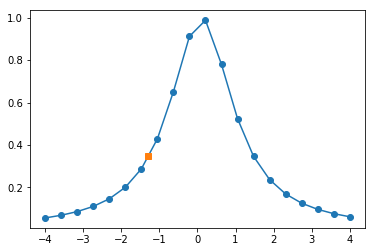

In [7]:
x = np.linspace(-4,4,20)
y = lorentzian(x, 1, 0.1, 2)
f = dUtil.MeasuredFunction(x, y)
f.simplePlot('-o')

y_command = .35
x_control = f.invert(y_command, directionToDescend='left')
plt.plot(x_control, y_command, 's')
print('The square should fall on the curve somewhere')